In [1]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib.colors import ListedColormap

In [2]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [3]:
dataset_name = 'Semantic segmentation dataset'
output_dir ='output_dir'
os.makedirs(output_dir, exist_ok=True)
test_data_folder = 'test_data_folder'

In [4]:
minmaxscaler = MinMaxScaler()


In [5]:
image_dataset = []
mask_dataset = []
image_patch_size = 256

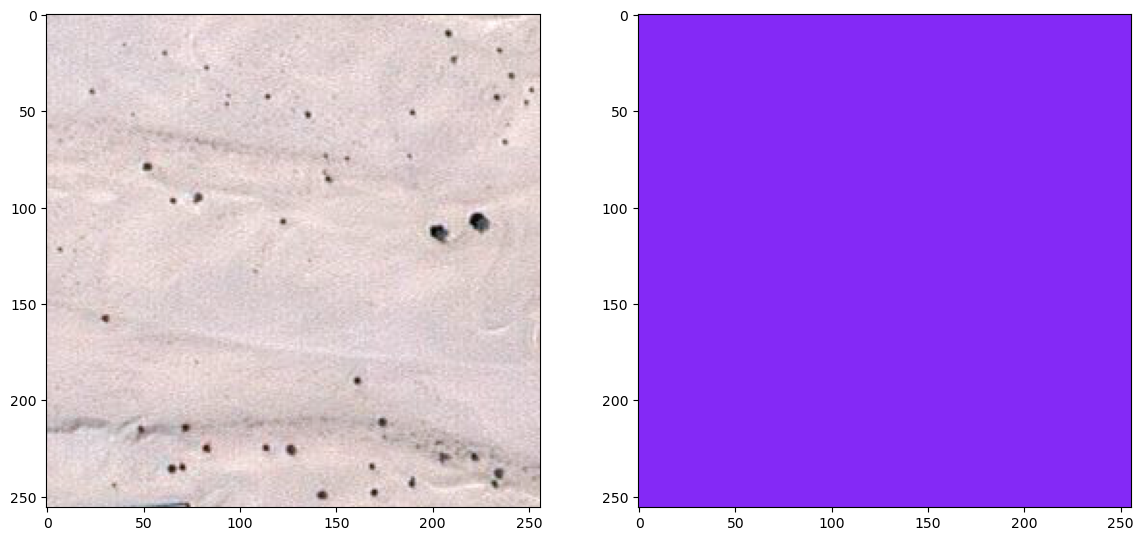

In [6]:
for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'

    for tile_id in range(1, 8):
        for image_id in range(1, 20):
            
            image_path = f'{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
            if not os.path.exists(image_path):
                #print(f"Warning: {image_path} does not exist. Skipping.")
                continue

            image = cv2.imread(image_path, 1)
                
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


6

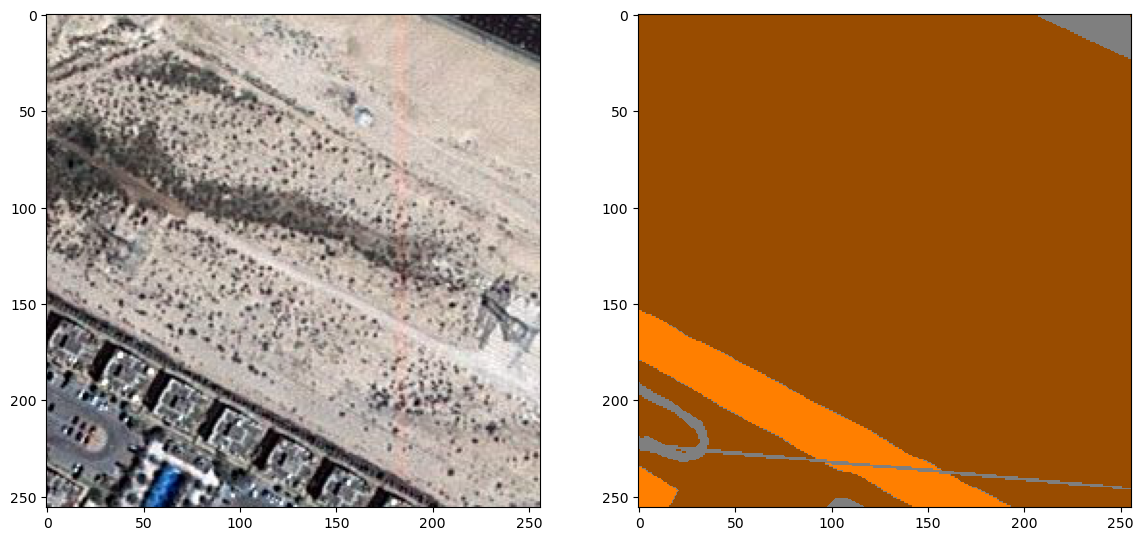

In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:, :, 0]
    return label_segment

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

# Define the colors for each class
colors = [
    (0, 0, 1),       # blue for water
    (0.6, 0.3, 0),   # brown for land
    (0.5, 0.5, 0.5), # grey for road
    (1, 0.5, 0),     # red for building
    (0, 1, 0),       # green for vegetation
    (0, 0, 0)        # black for unlabeled
]

# Create a colormap
cmap = ListedColormap(colors)

random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:, :, 0], cmap=cmap, vmin=0, vmax=5)  # vmin and vmax to set the range of the colormap

total_classes = len(np.unique(labels))
total_classes


In [8]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


In [9]:
labels.shape

(945, 256, 256, 1)

In [10]:
# Assuming total_classes is defined
total_classes = 6  # Example value, make sure it matches your data

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels, test_size=0.15, random_state=100)


# Convert datasets to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32) 
X_test = torch.tensor(X_test, dtype=torch.float32)

# Convert labels to one-hot encoding
def to_categorical(labels, num_classes):
    labels = labels.squeeze(-1)  # Remove the last dimension
    one_hot = np.eye(num_classes)[labels]  # Apply one-hot encoding
    return one_hot

# Convert the labels
y_train = to_categorical(y_train, num_classes=total_classes)
y_test = to_categorical(y_test, num_classes=total_classes)

# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



# Print shapes to verify
print("Shape of X_train:", X_train.shape)  # Expected shape: (num_samples, channels, height, width)
print("Shape of X_test:", X_test.shape)    # Expected shape: (num_samples, channels, height, width)
print("Shape of y_train:", y_train.shape)  # Expected shape: (num_samples, num_classes, height, width)
print("Shape of y_test:", y_test.shape)    # Expected shape: (num_samples, num_classes, height, width)

Shape of X_train: torch.Size([803, 256, 256, 3])
Shape of X_test: torch.Size([142, 256, 256, 3])
Shape of y_train: torch.Size([803, 256, 256, 6])
Shape of y_test: torch.Size([142, 256, 256, 6])


In [11]:

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]


print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [12]:
# Convert X_train and X_test to the NCHW format
X_train = X_train.permute(0, 3, 1, 2).float()  # From NHWC to NCHW
X_test = X_test.permute(0, 3, 1, 2).float()    # From NHWC to NCHW

# Ensure categorical labels for PyTorch in NCHW format (skip one_hot encoding)
y_train = y_train.permute(0, 3, 1, 2).float()  # From NHWC to NCHW
y_test = y_test.permute(0, 3, 1, 2).float()    # From NHWC to NCHW

# Print shapes to verify
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: torch.Size([803, 3, 256, 256])
Shape of X_test: torch.Size([142, 3, 256, 256])
Shape of y_train: torch.Size([803, 6, 256, 256])
Shape of y_test: torch.Size([142, 6, 256, 256])


**part 2**

In [13]:
# Define Jaccard Coefficient
def jaccard_coef(y_true, y_pred):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = (y_true_flat * y_pred_flat).sum()
    union = y_true_flat.sum() + y_pred_flat.sum() - intersection
    return (intersection + 1.0) / (union + 1.0)



In [14]:
# Define convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.3):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        return x

In [15]:
class UNet(nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super(UNet, self).__init__()

        # Increased the number of filters
        # Encoder (Downsampling)
        self.conv1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = ConvBlock(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = ConvBlock(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = ConvBlock(512, 1024)  # Bottleneck

        # Decoder (Upsampling)
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = ConvBlock(1024, 512)

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = ConvBlock(512, 256)

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = ConvBlock(256, 128)

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = ConvBlock(128, 64)

        # Final convolution
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder pathway
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        c5 = self.conv5(p4)  # Bottleneck

        # Decoder pathway with skip connections
        u6 = self.up6(c5)
        u6 = torch.cat([u6, c4], dim=1)  # Skip connection
        c6 = self.conv6(u6)

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c3], dim=1)  # Skip connection
        c7 = self.conv7(u7)

        u8 = self.up8(c7)
        u8 = torch.cat([u8, c2], dim=1)  # Skip connection
        c8 = self.conv8(u8)

        u9 = self.up9(c8)
        u9 = torch.cat([u9, c1], dim=1)  # Skip connection
        c9 = self.conv9(u9)

        # Output layer with softmax for segmentation probabilities
        output = self.final_conv(c9)
        output = F.softmax(output, dim=1)  # Apply softmax across the channel dimension
        return output

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, weights=None):
        super(DiceLoss, self).__init__()
        self.weights = weights

    def forward(self, y_true, y_pred):
        smooth = 1.0
        intersection = (y_true * y_pred).sum(dim=(2, 3))
        union = y_true.sum(dim=(2, 3)) + y_pred.sum(dim=(2, 3))
        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        if self.weights is not None:
            dice_score = dice_score * self.weights
        return 1 - dice_score.mean()



In [17]:
class CategoricalFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(CategoricalFocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, y_true, y_pred):
        epsilon = 1e-8
        y_pred = y_pred.clamp(epsilon, 1. - epsilon)
        ce_loss = -y_true * torch.log(y_pred)
        if self.alpha is not None:
            ce_loss = self.alpha * ce_loss
        focal_loss = ((1 - y_pred) ** self.gamma) * ce_loss
        return focal_loss.mean()


In [18]:
# Set up model, loss functions, and optimizer with modifications
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_classes=total_classes, in_channels=image_channels).to(device)

weights = torch.tensor([0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666], device=device)

dice_loss = DiceLoss(weights=weights)
focal_loss = CategoricalFocalLoss()
# Apply the softmax within the loss function if necessary
total_loss = lambda y_true, y_pred: 0.5 * dice_loss(y_true, y_pred) + 0.5 * focal_loss(y_true, y_pred)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)




In [19]:
# Assuming the model, X_train, y_train, X_test, y_test, total_loss, and optimizer are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 50
batch_size = 6
early_stopping_patience =10

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
early_stopping_counter = 0


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []



for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = total_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate training accuracy
        predicted = torch.argmax(outputs, dim=1)
        masks_argmax = torch.argmax(masks, dim=1)
        train_correct += (predicted == masks_argmax).sum().item()
        train_total += masks_argmax.numel()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = total_loss(outputs, masks)
            val_loss += loss.item()

            # Calculate validation accuracy
            predicted = torch.argmax(outputs, dim=1)
            masks_argmax = torch.argmax(masks, dim=1)
            val_correct += (predicted == masks_argmax).sum().item()
            val_total += masks_argmax.numel()

    val_loss /= len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping")
        break

print('Training finished.')

Epoch 1/50, Train Loss: 1.3715, Train Accuracy: 0.6262, Val Loss: 1.2356, Val Accuracy: 0.6418
Epoch 2/50, Train Loss: 1.1542, Train Accuracy: 0.6927, Val Loss: 1.0884, Val Accuracy: 0.7077
Epoch 3/50, Train Loss: 1.0594, Train Accuracy: 0.7205, Val Loss: 1.0457, Val Accuracy: 0.7095
Epoch 4/50, Train Loss: 1.0065, Train Accuracy: 0.7299, Val Loss: 0.9712, Val Accuracy: 0.7210
Epoch 5/50, Train Loss: 0.9588, Train Accuracy: 0.7425, Val Loss: 0.9080, Val Accuracy: 0.7535
Epoch 6/50, Train Loss: 0.9365, Train Accuracy: 0.7468, Val Loss: 0.8639, Val Accuracy: 0.8018
Epoch 7/50, Train Loss: 0.8954, Train Accuracy: 0.7719, Val Loss: 0.8584, Val Accuracy: 0.7819
Epoch 8/50, Train Loss: 0.8724, Train Accuracy: 0.7827, Val Loss: 0.8417, Val Accuracy: 0.7869
Epoch 9/50, Train Loss: 0.8729, Train Accuracy: 0.7741, Val Loss: 0.7897, Val Accuracy: 0.8184
Epoch 10/50, Train Loss: 0.8388, Train Accuracy: 0.7914, Val Loss: 0.8534, Val Accuracy: 0.7714
Epoch 11/50, Train Loss: 0.8243, Train Accuracy: 

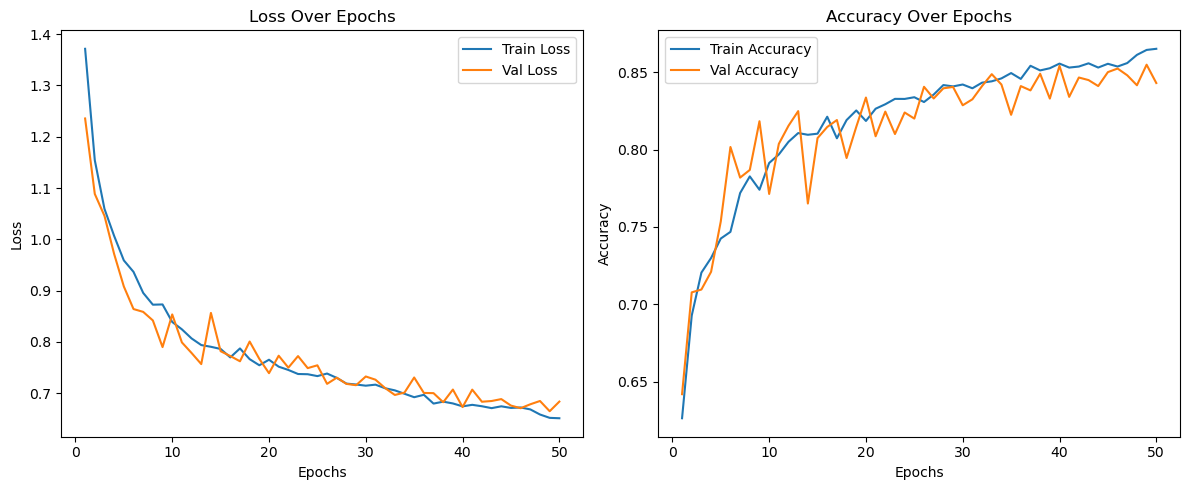

In [20]:
# Plotting loss and accuracy
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

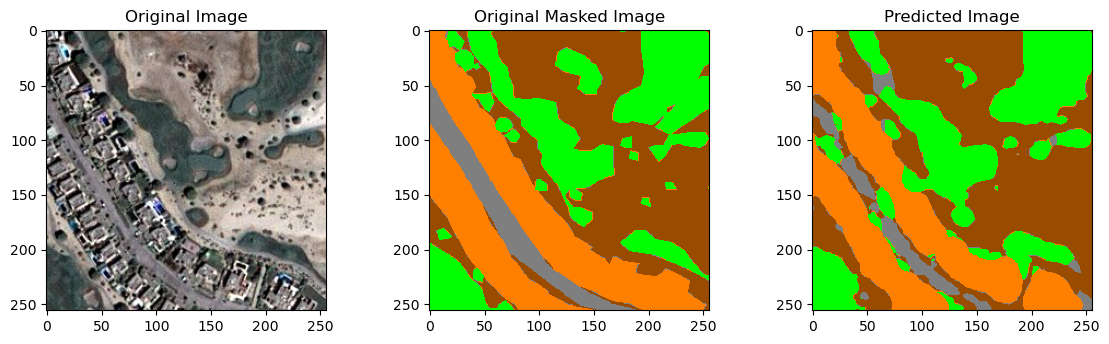

In [44]:
# Make sure the model is in evaluation mode
model.eval()
num_classes = 6

# Choose a random test image
test_image_number = random.randint(0, len(X_test) - 1)

# Retrieve the test image and ground truth
test_image = X_test[test_image_number]
ground_truth_image = y_test[test_image_number]

# Prepare the test image for the model
test_image_input = torch.unsqueeze(test_image, 0).to(device)  # Add batch dimension and move to device

# Generate prediction
with torch.no_grad():
    prediction = model(test_image_input)
    predicted_image = torch.argmax(prediction, dim=1).cpu().numpy()[0]  # Remove batch dimension and move to CPU

# Convert ground_truth_image from one-hot encoded format to class index format
ground_truth_image = torch.argmax(ground_truth_image, dim=0).cpu().numpy()

# Visualize the results
plt.figure(figsize=(14, 8))

# Original Image
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy())  # Change dimensions from CHW to HWC for display

# Original Masked Image
plt.subplot(232)
plt.title("Original Masked Image")
plt.imshow(ground_truth_image, cmap=cmap, vmin=0, vmax=num_classes-1)

# Predicted Image
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=num_classes-1)

plt.show()